# Neural Network Classification of Privacy Policy Data Practices

## August Karlstedt

In [1]:
%matplotlib inline

import os
import imp
import operator
import math
import glob
import json
import time
from collections import Counter

from IPython.display import IFrame

import nltk
from nltk.tokenize import word_tokenize

import numpy as np
import pandas as pd
import seaborn as sn

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

#import pickle
#from six.moves import urllib

import tensorflow

from hyperopt import Trials, STATUS_OK
import hyperopt
from hyperas import optim
from hyperas.distributions import choice, uniform, conditional

from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Dropout
from keras.layers import LSTM, TimeDistributed
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, TensorBoard
from keras import metrics
from keras.utils.np_utils import to_categorical

#import fasttext
# https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md

import gensim
# https://nlp.stanford.edu/projects/glove/

Using TensorFlow backend.
c:\users\august.karlstedt\appdata\local\programs\python\python36\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Prepare the Data

Let's setup the categories that we'll try to classify. We'll also need one-hot encodings that for the network.

From the OPP paper https://www.usableprivacy.org/static/files/swilson_acl_2016.pdf:

1. **First Party Collection/Use**: how and why a service provider collects user information.
2. **Third Party Sharing/Collection**: how user information may be shared with or collected by third parties. 
3. **User Choice/Control**: choices and control options available to users. 
4. **User Access, Edit, & Deletion**: if and how users may access, edit, or delete their information. 
5. **Data Retention**: how long user information is stored. 
6. **Data Security**: how user information is protected. 
7. **Policy Change**: if and how users will be in formed about changes to the privacy policy. 
8. **Do Not Track**: if and how Do Not Track signals 3 for online tracking and advertising are honored. 
9. **International & Specific Audiences**: practices that pertain only to a specific group of users (e.g., children, Europeans, or California residents). 
10. **Other**: additional sublabels for introductory or general text, contact information, and practices not covered by the other categories.

In [2]:
def get_annotations():
    filenames = []
    annotations = []
    
    header = ['Annotation ID', 'Batch ID', 'Annotator ID', 'Policy ID', 'Segment ID', 'Category Name', 'Attributes/Values', 'Policy URL', 'Date']
    keep_columns = ['Segment ID', 'Category Name', 'Attributes/Values']
    
    for file in glob.glob("data\\annotations/*.csv"):
        filenames.append(file[17:-4])
        annotations.append(pd.read_csv(file, names=header)[keep_columns])
    
    return filenames, annotations

In [3]:
def get_sanitized_policies(annotation_files):
    sanitized_policies = []
    
    for file in annotation_files:
        with open("data\\sanitized_policies/{}.html".format(file)) as f:
            sanitized_policies.append(f.readlines()[0].split('|||'))
            
    return sanitized_policies

In [4]:
def get_categories():
    categories = [
     'Data Retention', # 0
     'Data Security', # 1
     'Do Not Track', # 2
     'First Party Collection/Use', # 3
     'International and Specific Audiences', # 4
     'Other', # 5
     'Policy Change', # 6
     'Third Party Sharing/Collection', # 7
     'User Access, Edit and Deletion', # 8
     'User Choice/Control', # 9
     'None' # 10
    ]
    
    categories_one_hot = np.identity(len(categories))

    category_lookup_table = {
     categories[0]:  categories_one_hot[0],
     categories[1]:  categories_one_hot[1],
     categories[2]:  categories_one_hot[2],
     categories[3]:  categories_one_hot[3],
     categories[4]:  categories_one_hot[4],
     categories[5]:  categories_one_hot[5],
     categories[6]:  categories_one_hot[6],
     categories[7]:  categories_one_hot[7],
     categories[8]:  categories_one_hot[8],
     categories[9]:  categories_one_hot[9],
     categories[10]: categories_one_hot[10],
    }
    
    return categories, categories_one_hot, category_lookup_table

In [5]:
def get_attributes():
    
    attribute_value_types = ['Access Scope',
     'Access Type',
     'Action First-Party',
     'Action Third Party',
     'Audience Type',
     'Change Type',
     'Choice Scope',
     'Choice Type',
     'Collection Mode',
     'Do Not Track policy',
     'Does/Does Not',
     'Identifiability',
     'Notification Type',
     'Other Type',
     'Personal Information Type',
     'Purpose',
     'Retention Period',
     'Retention Purpose',
     'Security Measure',
     'Third Party Entity',
     'User Choice',
     'User Type'
    ]

    attribute_value_values = ['Additional service/feature',
     'Advertising',
     'Aggregated or anonymized',
     'Analytics/Research',
     'Basic service/feature',
     'Both',
     'Browser/device privacy controls',
     'Californians',
     'Children',
     'Citizens from other countries',
     'Collect from user on other websites',
     'Collect in mobile app',
     'Collect on first party website/app',
     'Collect on mobile website',
     'Collect on website',
     'Collection',
     'Computer information',
     'Contact',
     'Cookies and tracking elements',
     'Data access limitation',
     'Deactivate account',
     'Delete account (full)',
     'Delete account (partial)',
     'Demographic',
     'Does',
     'Does Not',
     'Dont use service/feature',
     'Edit information',
     'Europeans',
     'Explicit',
     'Export',
     'Financial',
     'First party collection',
     'First party use',
     'First-party privacy controls',
     'General notice in privacy policy',
     'General notice on website',
     'Generic',
     'Generic personal information',
     'Health',
     'Honored',
     'IP address and device IDs',
     'Identifiable',
     'Implicit',
     'In case of merger or acquisition',
     'Indefinitely',
     'Introductory/Generic',
     'Legal requirement',
     'Limited',
     'Location',
     'Marketing',
     'Mentioned, but unclear if honored',
     'Merger/Acquisition',
     'Named third party',
     'No notification',
     'Non-privacy relevant change',
     'None',
     'Not honored',
     'Not mentioned',
     'Opt-in',
     'Opt-out',
     'Opt-out link',
     'Opt-out via contacting company',
     'Other',
     'Other data about user',
     'Other part of company/affiliate',
     'Other users',
     'Perform service',
     'Personal identifier',
     'Personal notice',
     'Personalization/Customization',
     'Practice not covered',
     'Privacy contact information',
     'Privacy relevant change',
     'Privacy review/audit',
     'Privacy training',
     'Privacy/Security program',
     'Profile data',
     'Public',
     'Receive from other parts of company/affiliates',
     'Receive from other service/third-party (named)',
     'Receive from other service/third-party (unnamed)',
     'Receive/Shared with',
     'Secure data storage',
     'Secure data transfer',
     'Secure user authentication',
     'See',
     'Service Operation and Security',
     'Service operation and security',
     'Social media data',
     'Stated Period',
     'Survey data',
     'Third party sharing/collection',
     'Third party use',
     'Third-party privacy controls',
     'Track on first party website/app',
     'Track user on other websites',
     'Transactional data',
     'Unnamed third party',
     'Unspecified',
     'Use',
     'User Profile',
     'User account data',
     'User online activities',
     'User participation',
     'User profile',
     'User with account',
     'User without account',
     'View',
     'not-selected'
    ]
    
    return attribute_value_types, attribute_value_values

In [6]:
def get_chosen_categories():
    return ['First Party Collection/Use', 
            'Third Party Sharing/Collection', 
            'Other', 
            'User Choice/Control', 
            'Data Security',
            'International and Specific Audiences',
            'User Access, Edit and Deletion',
            'Policy Change',
            'Data Retention',
            'Do Not Track',
            'None' # added by us, not in original corpus
           ]

In [7]:
def get_text_to_remove():
    return ['null', 'Not selected']

In [8]:
def get_annotation_data(annotations, sanitized_policies, category_lookup_table):
    chosen_categories = get_chosen_categories()
    attribute_value_types, attribute_value_values = get_attributes()
    remove_text = get_text_to_remove()
    
    #stemmer = nltk.stem.porter.PorterStemmer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    
    idx = 0
    
    documents = []
    categories = []
    categories_one_hot = []
    category_lengths = Counter()
    
    remove_spans = {} # dictionary of policy ids and list of start, stop tuples that are then removed

    '''
    remove_spans structure:
    
    {
    "2": --> this is the policy id
      {
       "6": [(20, 30), (30, 50)], --> this is the segment id
       "8": [(40, 123)] --> which maps to a list of tuple of start, end indices
      }
    }
    '''
        
    ##  first process the annotations
    for annotation_idx in range(len(annotations)):
        annotation = annotations[annotation_idx]
        
        for idx in range(len(annotation)):        
            category = annotation['Category Name'][idx]

            if chosen_categories is None:
                continue

            if category not in chosen_categories:
                continue

            segment_id = annotation['Segment ID'][idx]
            
            if annotation_idx not in remove_spans:
                remove_spans[annotation_idx] = {}
                
            if segment_id not in remove_spans[annotation_idx]:
                remove_spans[annotation_idx][segment_id] = []

            # ok, we have our policy text, now we need to 
            # remove all of the spans that are associated with a category
            # so we can attribute that text to the 'None' category

            parsed = json.loads(annotation['Attributes/Values'][idx])
            for value in attribute_value_types:
                if value not in parsed.keys():
                    continue

                attributes = parsed[value]
                
                if 'selectedText' not in attributes:
                    continue
                    
                if 'startIndexInSegment' not in attributes:
                    continue
                    
                if 'endIndexInSegment' not in attributes:
                    continue

                text = attributes['selectedText']
                if text in remove_text:
                    continue
                    
                start_idx = attributes['startIndexInSegment']
                if start_idx == -1:
                    continue
                    
                end_idx = attributes['endIndexInSegment']
                if end_idx == -1:
                    continue

                remove_spans[annotation_idx][segment_id].append((start_idx, end_idx))

                text = text.lower()
                processed_text = word_tokenize(text)
                processed_text = [lemmatizer.lemmatize(word) for word in processed_text]

                doc = gensim.models.doc2vec.TaggedDocument(processed_text, [idx])
                documents.append(doc)
                
                categories.append(category)
                categories_one_hot.append(category_lookup_table[category])
                category_lengths[category] += 1
                
                idx += 1
    
    ## now process the remove spans from the policies
    if 'None' in chosen_categories:
        replace_items = ["<br>", "<strong>", "</strong>", "<ul>", "</ul>", "<li>", "</li>", "<ol>", "</ol>"]

        for policy_idx in remove_spans:
            policy = sanitized_policies[policy_idx]

            for segment_idx in remove_spans[policy_idx]:

                try:
                    policy_segment = policy[segment_idx]
                except IndexError as e:
                    #print(e, policy_idx, segment_idx)
                    continue

                segment_text = policy_segment
                for span in remove_spans[policy_idx][segment_idx]:
                    start_idx = span[0]
                    end_idx = span[1]
                    segment_text = segment_text[:start_idx] + " " + segment_text[end_idx:]

                segment_text = segment_text.lower()

                for item in replace_items:
                    segment_text = segment_text.replace(item, " ")

                segment_text = segment_text.strip()

                if not segment_text: # check if we have any characters at all
                    continue

                processed_text = word_tokenize(segment_text)
                processed_text = [lemmatizer.lemmatize(word) for word in processed_text]

                doc = gensim.models.doc2vec.TaggedDocument(processed_text, [idx])
                documents.append(doc)

                categories.append('None')
                categories_one_hot.append(category_lookup_table['None'])
                category_lengths['None'] += 1

                idx += 1
    
    return documents, categories_one_hot, categories, category_lengths

In [9]:
def train_embeddings(documents, epochs=16):
    model = gensim.models.Doc2Vec(vector_size=100)
    model.build_vocab(documents)
    model.train(documents, total_examples=len(documents), epochs=epochs)
    return model

In [10]:
def get_vector(model, text):
    # set this so it's deterministic
    model.random = np.random.RandomState(1234)
    return model.infer_vector(word_tokenize(text))

In [11]:
def get_data():
    filenames, annotations = get_annotations()
    sanitized_policies = get_sanitized_policies(filenames)
    _, _, category_lookup_table = get_categories()
    
    documents, categories_one_hot, categories, category_lengths = get_annotation_data(annotations, sanitized_policies, category_lookup_table)
    embedding_model = train_embeddings(documents)
    
    text_span_vectors = []
    for idx in range(len(categories)):
        text = ' '.join(documents[idx].words)
        vector = get_vector(embedding_model, text)
        text_span_vectors.append(vector)

    return text_span_vectors, categories_one_hot, categories, category_lengths

Since these Doc2Vec vectors are our only input data right now, let's just use them directly as our input data.

### Hyperparameter tuning setup

In [12]:
def data():
    text_span_vectors, categories_one_hot, _, _ = get_data()
    
    text_span_vectors = np.array(text_span_vectors)
    categories_one_hot = np.array(categories_one_hot)
    
    choice = np.random.choice(len(text_span_vectors), len(text_span_vectors), replace=False)
    test_percentage = 0.25 # keep 25% of data for testing
    test_amount = math.floor(0.25 * len(text_span_vectors))
    train_indices = np.array(choice[test_amount:])
    test_indices = np.array(choice[:test_amount])
    
    x_train = text_span_vectors[train_indices]
    x_test = text_span_vectors[test_indices]
    y_train = categories_one_hot[train_indices]
    y_test = categories_one_hot[test_indices]
    
    return x_train, y_train, x_test, y_test

### Neural Network Setup

For now, we'll use a simple neural network consisting of:

1. **Fully connected** layer with 256 nodes, relu activation
2. **Dropout** 25% of the inputs
3. **Fully connected** layer with 256 nodes, relu activation
4. **Dropout** 25% of the inputs
5. **Fully connected** layer with 11 nodes, softmax activation

In [13]:
def create_model(x_train, y_train, x_test, y_test):

    nn_model = Sequential()
    nn_model.add(Dense( {{choice([32, 64, 128, 256, 512, 1024])}}, batch_input_shape=(None, 100, )))
    nn_model.add(Activation( {{choice(['relu', 'tanh', 'sigmoid'])}} ))
    
    #if conditional( {{choice(['dropout', 'no dropout'])}} ) == 'dropout':
    #    nn_model.add(Dropout( {{uniform(0, 1)}} ))
    
    nn_model.add(Dense(11))
    nn_model.add(Activation('softmax'))
    
    nn_model.compile(loss='categorical_crossentropy', optimizer={{choice(['sgd', 'rmsprop', 'adagrad', 'adam', 'nadam'])}}, metrics=[metrics.categorical_accuracy])

    #print(nn_model.summary())

    tensorboard_callback = TensorBoard(log_dir='C:/tmp/pp_run-'+time.strftime("%Y-%m-%d-%H%M%S"))
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1, mode='auto')
    
    history = nn_model.fit(x_train, y_train, batch_size=128, epochs=64, verbose=2, validation_data=(x_test, y_test), callbacks=[early_stopping, tensorboard_callback])
    
    acc = history.history['val_categorical_accuracy'][-1]
    print('Test accuracy:', acc)
    
    return {'loss': -acc, 'status': STATUS_OK, 'model': nn_model}

In [14]:
IFrame('http://localhost:6006', '100%', 800)

In [15]:
functions=[get_data, get_vector, train_embeddings, get_annotation_data, get_text_to_remove, get_chosen_categories, get_attributes, get_categories, get_sanitized_policies, get_annotations]
best_run, best_model = optim.minimize(model=create_model, data=data, functions=functions, algo=hyperopt.rand.suggest, max_evals=4, trials=Trials(), notebook_name='Privacy Policies and Neural Networks')
X_train, Y_train, X_test, Y_test = data()
print("Evalutation of best performing model:")
print(best_model.evaluate(X_test, Y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)

>>> Imports:
#coding=utf-8

try:
    import os
except:
    pass

try:
    import imp
except:
    pass

try:
    import operator
except:
    pass

try:
    import math
except:
    pass

try:
    import glob
except:
    pass

try:
    import json
except:
    pass

try:
    import time
except:
    pass

try:
    from collections import Counter
except:
    pass

try:
    from IPython.display import IFrame
except:
    pass

try:
    import nltk
except:
    pass

try:
    from nltk.tokenize import word_tokenize
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import seaborn as sn
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    from sklearn.preprocessing import LabelEncoder, OneHotEncoder
except:
    pass

try:
    import tensorflow
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK
except:
    pass

try:
    import hyperopt
except:
    pass

try:
    from hyperas import

Train on 59753 samples, validate on 19917 samples
Epoch 1/64
 - 1s - loss: 1.4295 - categorical_accuracy: 0.4820 - val_loss: 1.3393 - val_categorical_accuracy: 0.4999
Epoch 2/64
 - 1s - loss: 1.3160 - categorical_accuracy: 0.5078 - val_loss: 1.3104 - val_categorical_accuracy: 0.5114
Epoch 3/64
 - 1s - loss: 1.2914 - categorical_accuracy: 0.5186 - val_loss: 1.2905 - val_categorical_accuracy: 0.5237
Epoch 4/64
 - 2s - loss: 1.2734 - categorical_accuracy: 0.5274 - val_loss: 1.2793 - val_categorical_accuracy: 0.5242
Epoch 5/64
 - 2s - loss: 1.2592 - categorical_accuracy: 0.5317 - val_loss: 1.2699 - val_categorical_accuracy: 0.5301
Epoch 6/64
 - 3s - loss: 1.2482 - categorical_accuracy: 0.5339 - val_loss: 1.2594 - val_categorical_accuracy: 0.5330
Epoch 7/64
 - 3s - loss: 1.2398 - categorical_accuracy: 0.5361 - val_loss: 1.2548 - val_categorical_accuracy: 0.5332
Epoch 8/64
 - 3s - loss: 1.2323 - categorical_accuracy: 0.5380 - val_loss: 1.2518 - val_categorical_accuracy: 0.5312
Epoch 9/64
 - 

Epoch 15/64
 - 2s - loss: 1.1159 - categorical_accuracy: 0.5853 - val_loss: 1.1567 - val_categorical_accuracy: 0.5727
Epoch 16/64
 - 2s - loss: 1.1094 - categorical_accuracy: 0.5877 - val_loss: 1.1512 - val_categorical_accuracy: 0.5748
Epoch 17/64
 - 2s - loss: 1.1038 - categorical_accuracy: 0.5884 - val_loss: 1.1520 - val_categorical_accuracy: 0.5760
Epoch 18/64
 - 3s - loss: 1.0980 - categorical_accuracy: 0.5923 - val_loss: 1.1460 - val_categorical_accuracy: 0.5748
Epoch 19/64
 - 3s - loss: 1.0921 - categorical_accuracy: 0.5964 - val_loss: 1.1485 - val_categorical_accuracy: 0.5761
Epoch 20/64
 - 4s - loss: 1.0874 - categorical_accuracy: 0.5965 - val_loss: 1.1415 - val_categorical_accuracy: 0.5767
Epoch 21/64
 - 3s - loss: 1.0825 - categorical_accuracy: 0.5990 - val_loss: 1.1396 - val_categorical_accuracy: 0.5811
Epoch 22/64
 - 3s - loss: 1.0775 - categorical_accuracy: 0.6009 - val_loss: 1.1366 - val_categorical_accuracy: 0.5789
Epoch 00022: early stopping
Test accuracy: 0.57890244522

### Testing

To generate our confusion matrix, we need the indices

In [16]:
text_span_vectors, categories_one_hot, categories, category_lengths = get_data()

In [17]:
categories_array, _, category_lookup_table = get_categories()

In [18]:
df = pd.DataFrame([], columns=['text_span_vectors', 'categories_one_hot', 'category'])
df['text_span_vectors'] = text_span_vectors
df['categories_one_hot'] = categories_one_hot
df['category'] = categories
df

,text_span_vectors,categories_one_hot,category
0,"[0.1963776, -0.3738303, 0.17286246, 0.20250027...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",Other
1,"[0.023603281, -0.08504586, 0.076361455, 0.0642...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",First Party Collection/Use
2,"[0.053924445, -0.15980057, 0.16848347, 0.05761...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",First Party Collection/Use
3,"[0.07575981, -0.03278539, 0.040991012, 0.03030...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",First Party Collection/Use
4,"[-0.093279265, -0.12696974, 0.13961399, 0.0596...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",First Party Collection/Use
5,"[0.023603281, -0.08504586, 0.076361455, 0.0642...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",First Party Collection/Use
6,"[0.053924445, -0.15980057, 0.16848347, 0.05761...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",First Party Collection/Use
7,"[0.018047255, -0.051483583, 0.0950175, 0.06289...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",First Party Collection/Use
8,"[-0.093279265, -0.12696974, 0.13961399, 0.0596...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",First Party Collection/Use
9,"[0.010338852, -0.011947827, 0.038795933, 0.065...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Data Retention


In [19]:
for key, value in category_lengths.items():
    print(key, value)

Other 3544
First Party Collection/Use 37299
Data Retention 942
International and Specific Audiences 937
User Choice/Control 6146
Third Party Sharing/Collection 25024
User Access, Edit and Deletion 1691
Policy Change 1225
Data Security 1008
Do Not Track 90
None 1764


In [22]:
predictions = best_model.predict(np.array(text_span_vectors))

In [23]:
confusion_matrix_columns = get_chosen_categories()
confusion_matrix = pd.DataFrame([], columns=confusion_matrix_columns)

for category in get_chosen_categories():
    row = pd.DataFrame([np.zeros(len(confusion_matrix_columns), dtype=np.int64)], columns=confusion_matrix_columns, index=[category])
    
    examples = df.loc[df['category'] == category]
    indices = examples.index
    
    pred = predictions[indices]
   
    for i in range(len(indices)):
        predicted_category = categories_array[np.argmax(np.round(pred[i]))]
        row[predicted_category] += 1
        
    row /= category_lengths[category]
        
    confusion_matrix = confusion_matrix.append(row)  
    
confusion_matrix

,First Party Collection/Use,Third Party Sharing/Collection,Other,User Choice/Control,Data Security,International and Specific Audiences,"User Access, Edit and Deletion",Policy Change,Data Retention,Do Not Track,None
First Party Collection/Use,0.461675,0.165098,0.012172,0.001421,0.000188,0.000349,0.005014,0.000563,0.352959,0.0,0.000563
Third Party Sharing/Collection,0.295836,0.332281,0.014826,0.000959,0.000360,0.000559,0.005834,0.000559,0.348266,0.0,0.000520
Other,0.244921,0.080135,0.257901,0.002540,0.003668,0.010440,0.011569,0.008747,0.377822,0.0,0.002257
User Choice/Control,0.342987,0.139278,0.032541,0.008461,0.000814,0.000814,0.009762,0.003091,0.461601,0.0,0.000651
Data Security,0.317460,0.044643,0.123016,0.002976,0.035714,0.007937,0.007937,0.006944,0.451389,0.0,0.001984
International and Specific Audiences,0.216649,0.096051,0.161153,0.000000,0.001067,0.112060,0.011740,0.003202,0.394877,0.0,0.003202
"User Access, Edit and Deletion",0.196334,0.109994,0.025429,0.003548,0.000591,0.001183,0.127735,0.001774,0.532821,0.0,0.000591
Policy Change,0.296327,0.040000,0.041633,0.000000,0.004082,0.000000,0.026939,0.026122,0.564898,0.0,0.000000
Data Retention,0.366242,0.161359,0.018047,0.003185,0.002123,0.000000,0.025478,0.001062,0.421444,0.0,0.001062
Do Not Track,0.477778,0.022222,0.077778,0.000000,0.000000,0.000000,0.000000,0.000000,0.411111,0.0,0.011111


In [24]:
confusion_matrix = confusion_matrix.infer_objects()

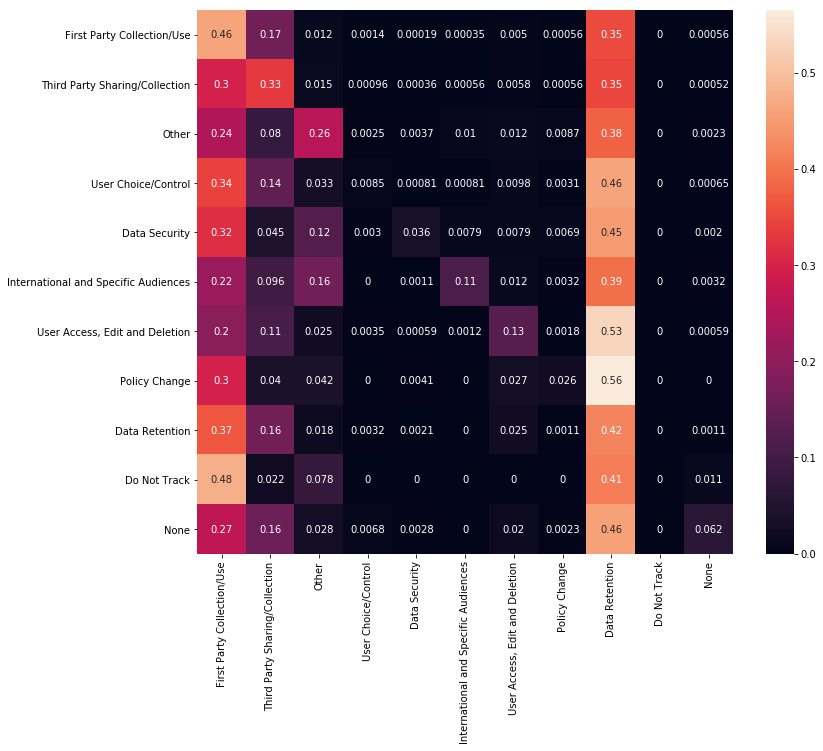

In [25]:
plt.figure(figsize=(12,10))
sn.heatmap(confusion_matrix, annot=True)